In [ ]:
# Ref: GPTZero API, https://huggingface.co/docs/transformers/perplexity, https://github.com/BurhanUlTayyab/DetectGPT

In [ ]:
!pip -q install transformers==4.26.0

In [ ]:
from collections import OrderedDict
import re
import torch
import statistics
import numpy as np

from transformers import GPT2LMHeadModel, GPT2TokenizerFast

class Detector:
  """
      The scoring model here is based on GPT-2

      stride: number of tokens forward to move after each prediction. 1 for the most precise result,
              but to reduce computation time, move by larger strides.

      threshold: the classification threshold between human vs. AI
    """
  def __init__(self, device="cuda", stride = 100, threshold = 63.5):
    self.device = device
    self.stride = stride
    self.threshold = threshold

    self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    self.max_length = self.model.config.n_positions

  def run(self, sentence):
    """
      Takes in a sentence split by full stop and print the perplexity of the total sentence
      split the lines based on full stop and find the perplexity of each sentence
      and print average perplexity

      Burstiness is the max perplexity of each sentence
    """
    results = OrderedDict()

    lines = re.split(r'(?<=[.?!][ \[\(])|(?<=\n)\s*', sentence)
    lines = list(filter(lambda x: (x is not None) and (len(x) > 0), lines))
    lines = [l.strip() for l in lines]

    # Compute of whole text
    ppl, nll = self.compute_ppl(sentence)
    results["Overall Perplexity"] = ppl.item()

    # Compute per sentence
    offset = ""
    ppl_per_line = []
    nll_per_line = []
    max_ppl = float('-inf')
    max_ppl_line = ""
    for i, line in enumerate(lines):
        if re.search("[a-zA-Z0-9]+", line) == None:
            continue
        if line == '':
            continue
        if len(offset) > 0:
            line = offset + line
            offset = ""
        # remove the new line pr space in the first sentence if exists
        if line[0] == "\n" or line[0] == " ":
            line = line[1:]
        if line[-1] == "\n" or line[-1] == " ":
            line = line[:-1]
        elif line[-1] == "[" or line[-1] == "(":
            offset = line[-1]
            line = line[:-1]

        # compute ppl
        ppl, nll = self.compute_ppl(line)
        if not np.isnan(ppl).any() and not np.isnan(nll).any():
          ppl_per_line.append(ppl)
          nll_per_line.append(nll)
          # print(line)
          # print(ppl)
          # print(nll)

        # update max ppl
        if ppl > max_ppl:
          max_ppl = ppl
          max_ppl_line = line
    # update results
    results["Average Perplexity Score"] = (sum(ppl_per_line)/len(ppl_per_line)).item()
    results["Average Log Likelihood"] = (sum(nll_per_line)/len(nll_per_line)).item()
    results["Max Perplexity"] = max_ppl.item()
    results["Max Perplexity Line"] = max_ppl_line

    # Copmute brustiness
    ppl_vals = [tensor.item() for tensor in ppl_per_line]
    results["Burstiness Score"] = statistics.stdev(ppl_vals)

    return results

  def compute_ppl(self, sentence):
    encodings = self.tokenizer(sentence, return_tensors="pt")
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, self.stride):
        end_loc = min(begin_loc + self.max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(self.device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = self.model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    nll = -1 * torch.stack(nlls).sum() / end_loc
    return ppl, nll

  def classify(self, score):
    if score < self.threshold:
       return "The Text is likely generated by AI."
    else:
      return "The Text is likely written by Human."

In [ ]:
# Load data
import pandas as pd
df = pd.read_csv("/content/GPT-wiki-intro_500.csv")
df

,Unnamed: 0,id,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens
0,0,63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88
1,1,279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101
2,2,287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65
3,3,26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150
4,4,38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,50146274,https://en.wikipedia.org/wiki/2016%E2%80%9317%...,2016–17 National League,"The 2016–17 National League season, known as t...","The 2016–17 National League season, known as t...",3,164,252,200 word wikipedia style introduction on '2016...,the 108th season of professional baseball in ...,28,300
496,496,57809290,https://en.wikipedia.org/wiki/CAINE%20Linux,CAINE Linux,CAINE Linux (Computer Aided INvestigative Envi...,CAINE Linux (Computer Aided INvestigative Envi...,2,181,96,200 word wikipedia style introduction on 'CAIN...,a Debian-based distribution that incorporates...,30,119
497,497,10578490,https://en.wikipedia.org/wiki/Meat%20ant,Meat ant,"The meat ant (Iridomyrmex purpureus), also kno...","The meat ant (Iridomyrmex purpureus), also kno...",2,271,56,200 word wikipedia style introduction on 'Meat...,"as the Australian meat ant, is a species of a...",31,65
498,498,2921616,https://en.wikipedia.org/wiki/Caradog,Caradog,"Caradog, Caradoc, Caradawg, or Cradawg, Latini...","Caradog, Caradoc, Caradawg, or Cradawg, Latini...",1,156,172,200 word wikipedia style introduction on 'Cara...,"Caratacus, Caratacus, or Caratacus (1st centu...",38,229


In [ ]:
# Load model
detector = Detector(device = "cpu")

In [ ]:
# Compute ppl for training set

human_results = []
human_ai_results = []
ai_results = []

for i, row in df.iterrows():
  try:
    human_result = detector.run(row["wiki_intro"])
    human_result['id'] = row['id']
    human_results.append(human_result)

    human_ai_result = detector.run(row["generated_intro"])
    human_ai_result['id'] = row['id']
    human_ai_results.append(human_ai_result)

    ai_result = detector.run(row["generated_text"])
    ai_result['id'] = row['id']
    ai_results.append(ai_result)
  except Exception as e:
    print(i, e)
    continue



113 variance requires at least two data points
397 variance requires at least two data points


KeyboardInterrupt: ignored

In [ ]:
human_df = pd.DataFrame(human_results)
human_df.to_csv("human_df.csv")

In [ ]:
human_ai_df = pd.DataFrame(human_ai_results)
human_ai_df.to_csv("human_ai_df.csv")

In [ ]:
ai_df = pd.DataFrame(ai_results)
ai_df.to_csv("ai_df.csv")

In [ ]:
import numpy as np

def remove_outliers(data, threshold=3):
    """
    Removes outliers from a list of data using the z-score method.

    Args:
        data (list): List of numeric data.
        threshold (float): Number of standard deviations from the mean to consider as an outlier.

    Returns:
        list: List with outliers removed.
    """
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    filtered_data = [x for x, z in zip(data, z_scores) if abs(z) <= threshold]
    return filtered_data


human_scores = remove_outliers([score for score in human_df["Average Perplexity Score"] if score < 300])
human_ai_scores = remove_outliers([score for score in human_ai_df["Average Perplexity Score"] if score < 300])
ai_scores = remove_outliers([score for score in ai_df["Average Perplexity Score"] if score < 300])

sum(human_scores) / len(human_scores), sum(human_ai_scores) / len(human_ai_scores), sum(ai_scores) / len(ai_scores)

(110.08513991284433, 44.59101563141125, 46.6814587693143)

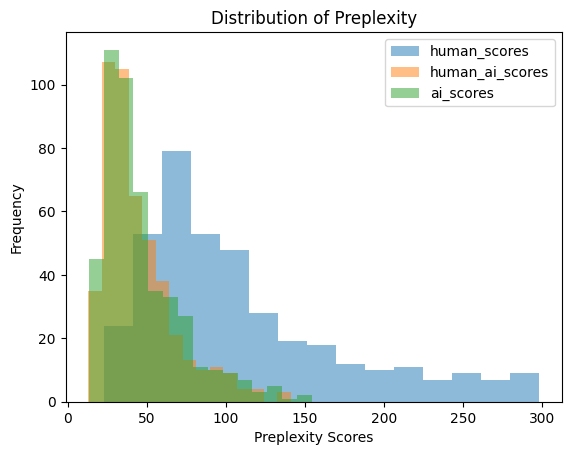

In [ ]:
import matplotlib.pyplot as plt
plt.hist(human_scores, bins=15, alpha=0.5, label = "human_scores")
plt.hist(human_ai_scores, bins=15, alpha=0.5, label = "human_ai_scores")
plt.hist(ai_scores, bins=15, alpha=0.5, label = "ai_scores")
plt.xlabel('Preplexity Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Preplexity')
plt.legend()
plt.show()


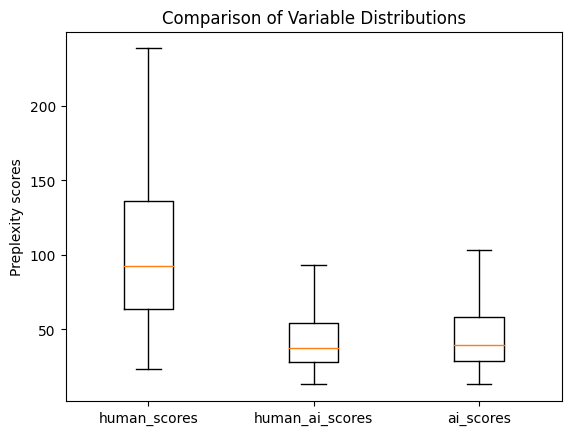

In [ ]:
data = [human_scores, human_ai_scores, ai_scores]

# Create a figure and axis object
fig, ax = plt.subplots()

# Create the box plot
ax.boxplot(data, showfliers=False)

# Customize the plot
ax.set_xticklabels(['human_scores', 'human_ai_scores', 'ai_scores'])  # Set x-axis labels
ax.set_ylabel('Preplexity scores')  # Set y-axis label
ax.set_title('Comparison of Preplexity Distributions')  # Set title

# Show the plot
plt.show()


In [ ]:
# score < threshold ->  AI
# score > threshold -> human

# TP = AI classified as AI
# FN = AI classified as human
# FP = Human classified as AI
# TN = Human classified as Human

# precision = TP / (TP + FP)
# recall =  TP / (TP + FN)


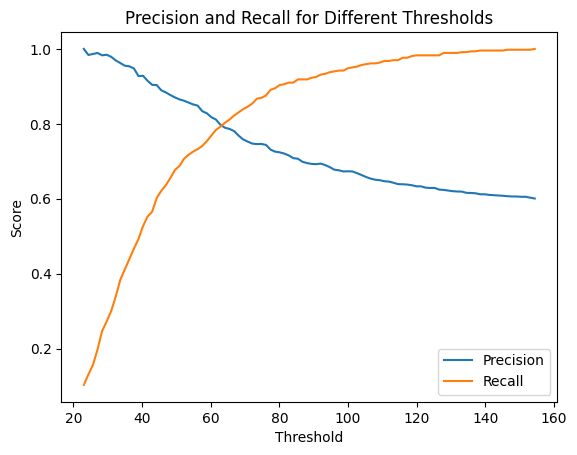

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_threshold(human_scores, ai_scores, threshold):
    human_scores = np.array(human_scores)
    ai_scores = np.array(ai_scores)

    true_positive = np.sum(ai_scores < threshold)
    false_positive = np.sum(human_scores < threshold)
    false_nagative = np.sum(ai_scores > threshold)

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_nagative)

    return precision, recall

def plot_evaluation(human_scores, ai_scores):
    thresholds = np.linspace(min(human_scores), max(ai_scores), num=100)  # Generate a range of thresholds
    precisions = []
    recalls = []

    for threshold in thresholds:
        precision, recall = evaluate_threshold(human_scores, ai_scores, threshold)
        precisions.append(precision)
        recalls.append(recall)

    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Different Thresholds')
    plt.legend()
    plt.show()

plot_evaluation(human_scores, ai_scores)

In [ ]:
threshold = 30
precision, recall = evaluate_threshold(human_scores, ai_scores, threshold)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

true_positive = np.sum(np.array(ai_scores) < threshold) / len(ai_scores)
false_positive = np.sum(np.array(human_scores) < threshold) / len(human_scores)
false_nagative = np.sum(np.array(ai_scores) > threshold) / len(ai_scores)
true_negative = np.sum(np.array(human_scores) > threshold) / len(human_scores)

print(f"(FP) {false_positive:.2f} Human as AI")
print(f"(FN) {false_nagative:.2f} AI as Human")

Precision: 0.99, Recall: 0.28
(FP) 0.01 Human as AI
(FN) 0.72 AI as Human


In [ ]:
threshold = 40
precision, recall = evaluate_threshold(human_scores, ai_scores, threshold)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

true_positive = np.sum(np.array(ai_scores) < threshold) / len(ai_scores)
false_positive = np.sum(np.array(human_scores) < threshold) / len(human_scores)
false_nagative = np.sum(np.array(ai_scores) > threshold) / len(ai_scores)
true_negative = np.sum(np.array(human_scores) > threshold) / len(human_scores)

print(f"(FP) {false_positive:.2f} Human as AI")
print(f"(FN) {false_nagative:.2f} AI as Human")

Precision: 0.93, Recall: 0.52
(FP) 0.05 Human as AI
(FN) 0.48 AI as Human


In [ ]:
threshold = 63.5
precision, recall = evaluate_threshold(human_scores, ai_scores, threshold)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

true_positive = np.sum(np.array(ai_scores) < threshold) / len(ai_scores)
false_positive = np.sum(np.array(human_scores) < threshold) / len(human_scores)
false_nagative = np.sum(np.array(ai_scores) > threshold) / len(ai_scores)
true_negative = np.sum(np.array(human_scores) > threshold) / len(human_scores)

print(f"(FP) {false_positive:.2f} Human as AI")
print(f"(FN) {false_nagative:.2f} AI as Human")

Precision: 0.79, Recall: 0.79
(FP) 0.25 Human as AI
(FN) 0.21 AI as Human
